In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('..')
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from tqdm import tqdm

from odcd.models.losses import elbo
from odcd.od.vae import OutlierVAE
from odcd.utils.perturbation import apply_mask
from odcd.utils.saving import save_od, load_od
from odcd.utils.visualize import plot_instance_outlier, plot_feature_outlier_image

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Load CIFAR10 data

In [2]:
train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

170500096/170498071 [==============================] - 9s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


## Load or define outlier detector

In [7]:
load_outlier_detector = True

In [13]:
filepath = './vae_outlier_detector/'
if load_outlier_detector:  # load pretrained outlier detector
    od = load_od(filepath)
else:  # define model, initialize, train and save outlier detector
    latent_dim = 1024
    
    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(32, 32, 3)),
          Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
      ])

    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(4*4*128),
          Reshape(target_shape=(4, 4, 128)),
          Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
      ])
    
    # initialize outlier detector
    od = OutlierVAE(threshold=.015,  # threshold for outlier score
                    score_type='mse',  # use MSE of reconstruction error for outlier detection
                    encoder_net=encoder_net,  # can also pass VAE model instead
                    decoder_net=decoder_net,  # of separate encoder and decoder
                    latent_dim=latent_dim,
                    samples=2)
    # train
    od.fit(X_train, 
           loss_fn=elbo,
           cov_elbo=dict(sim=.05),
           epochs=50,
           verbose=False)
    
    # save the trained outlier detector
    save_od(od, filepath)

In [39]:
import torch
import torchvision
import torchvision.transforms as transforms
import requests
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

0it [00:00, ?it/s]

170500096it [00:09, 18426481.34it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data


In [43]:
images[0]

tensor([[[ 0.2392,  0.2471,  0.2941,  ...,  0.0745, -0.0118, -0.0902],
         [ 0.1922,  0.1843,  0.2471,  ...,  0.0667, -0.0196, -0.0667],
         [ 0.1843,  0.1843,  0.2392,  ...,  0.0902,  0.0196, -0.0588],
         ...,
         [-0.4667, -0.6706, -0.7569,  ..., -0.7020, -0.8980, -0.6863],
         [-0.5216, -0.6157, -0.7255,  ..., -0.7961, -0.7725, -0.8431],
         [-0.5765, -0.5608, -0.6471,  ..., -0.8118, -0.7333, -0.8353]],

        [[-0.1216, -0.1294, -0.0902,  ..., -0.2549, -0.2863, -0.3333],
         [-0.1216, -0.1373, -0.1059,  ..., -0.2549, -0.2863, -0.3098],
         [-0.1373, -0.1451, -0.1294,  ..., -0.2314, -0.2549, -0.3020],
         ...,
         [-0.0275, -0.2157, -0.3098,  ..., -0.2392, -0.4980, -0.3333],
         [-0.0902, -0.2000, -0.3333,  ..., -0.3569, -0.3569, -0.4980],
         [-0.1608, -0.1765, -0.3020,  ..., -0.3961, -0.3412, -0.4745]],

        [[-0.6157, -0.6314, -0.6000,  ..., -0.7176, -0.7176, -0.7412],
         [-0.6000, -0.6863, -0.6471,  ..., -0

In [86]:

def getImage(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

In [46]:
images, labels = dataiter.next()

In [87]:
images[2].shape
npimg = getImage(img)

In [88]:
np.min(npimg)

0.0

In [89]:
npimg.shape

(32, 32, 3)

In [90]:
X_train.shape

(50000, 32, 32, 3)

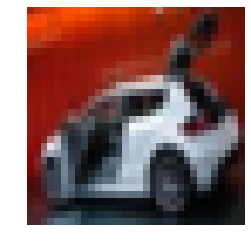

In [94]:
idx = 8
X = npimg.reshape(1, 32, 32, 3)
X_recon = od.vae(X)
plt.imshow(X.reshape(32, 32, 3))
plt.axis('off')
plt.show()

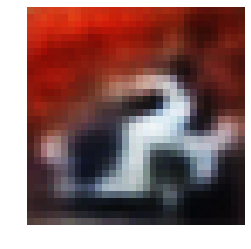

In [95]:
plt.imshow(X_recon.numpy().reshape(32, 32, 3))
plt.axis('off')
plt.show()

In [96]:
od_preds = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)
print(list(od_preds['data'].keys()))
print(od_preds)

['is_outlier', 'feature_score', 'instance_score']
{'data': {'is_outlier': array([0]), 'feature_score': array([[[[1.1880277e-02, 3.6991209e-02, 1.4641182e-02],
         [5.5977888e-03, 7.4371109e-03, 9.9036675e-03],
         [6.9625617e-05, 6.7579595e-04, 4.6417746e-03],
         ...,
         [2.8970218e-05, 6.4296450e-04, 5.6165241e-04],
         [2.8689654e-04, 2.1264364e-04, 1.6871577e-03],
         [9.2159683e-04, 1.5867577e-03, 2.1316125e-03]],

        [[1.0286843e-02, 1.3078460e-03, 5.3818822e-03],
         [1.1551367e-02, 1.5983268e-03, 5.7295542e-03],
         [6.2261019e-03, 1.8459677e-03, 4.4235364e-03],
         ...,
         [3.1517595e-03, 2.0093885e-05, 1.8611817e-04],
         [4.4524952e-04, 1.1058761e-05, 1.0069401e-03],
         [1.4093033e-03, 6.6699443e-04, 8.8888907e-04]],

        [[3.8623184e-02, 2.7495446e-03, 1.1814066e-02],
         [1.3774964e-02, 3.6664726e-03, 7.4814204e-03],
         [6.5440144e-03, 3.7967865e-03, 7.9631731e-03],
         ...,
         [5

## Check quality VAE model

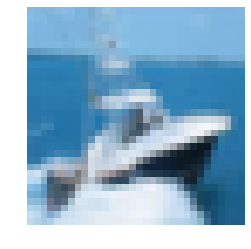

In [92]:
idx = 8
X = X_train[idx].reshape(1, 32, 32, 3)
X_recon = od.vae(X)
plt.imshow(X.reshape(32, 32, 3))
plt.axis('off')
plt.show()

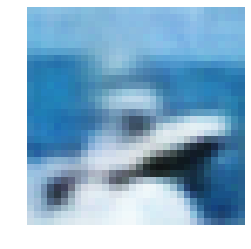

In [16]:
plt.imshow(X_recon.numpy().reshape(32, 32, 3))
plt.axis('off')
plt.show()

## Check outliers on original CIFAR images

In [17]:
X = X_train[:500]
print(X.shape)

(500, 32, 32, 3)


In [93]:
od_preds = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)
print(list(od_preds['data'].keys()))
print(od_preds)

['is_outlier', 'feature_score', 'instance_score']
{'data': {'is_outlier': array([0]), 'feature_score': array([[[[2.72402773e-04, 9.23185318e-04, 2.18906880e-05],
         [2.82251043e-04, 1.85370119e-03, 8.94890050e-04],
         [1.98690733e-03, 2.70403828e-03, 2.23882496e-03],
         ...,
         [2.04661002e-04, 1.43130208e-04, 5.80202141e-05],
         [4.55950503e-05, 4.56741895e-04, 1.35896589e-05],
         [2.21426555e-04, 5.87631839e-05, 8.09086050e-05]],

        [[2.57072708e-04, 7.87118188e-05, 6.37800695e-05],
         [4.93142797e-05, 5.49276592e-05, 6.38142810e-05],
         [6.24542474e-04, 4.01214813e-04, 7.24703568e-05],
         ...,
         [2.19356050e-04, 1.34698799e-04, 5.28476958e-05],
         [6.31568910e-05, 1.06761261e-04, 5.46743831e-05],
         [4.52539767e-04, 1.10788984e-04, 2.00349605e-05]],

        [[1.87999557e-03, 3.03183551e-05, 2.48138851e-04],
         [1.05751620e-03, 2.43914583e-05, 4.58639006e-05],
         [3.11957228e-05, 5.11130318e-0

### Plot instance level outlier scores

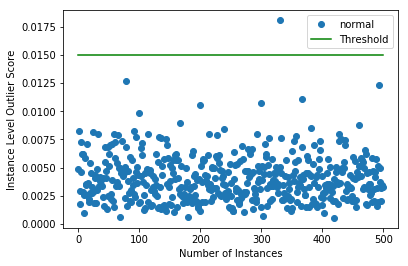

In [19]:
target = np.zeros(X.shape[0],).astype(int)  # all normal CIFAR10 training instances
labels = ['normal', 'outlier']
plot_instance_outlier(od_preds, target, labels, od.threshold)

### Visualize outliers

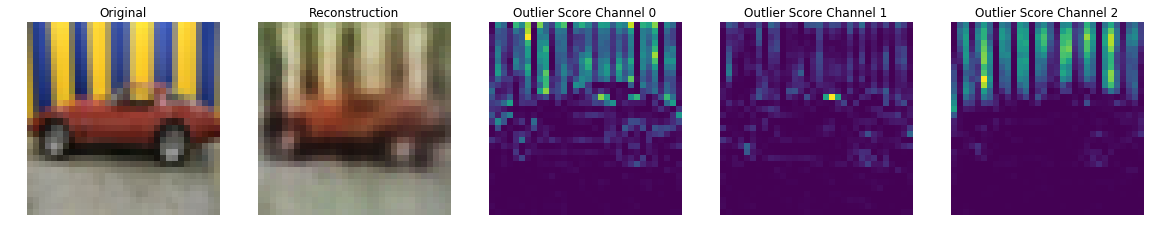

In [20]:
X_recon = od.vae(X).numpy()
plot_feature_outlier_image(od_preds, X, X_recon, outliers_only=True, max_outliers=5)

## Predict outliers on perturbed CIFAR images

We perturb CIFAR images by adding random noise to patches (masks) of the image. For each mask size in `n_mask_sizes`, sample `n_masks` and apply those to each of the `n_imgs` images. Then we predict outliers on the masked instances: 

In [21]:
# nb of predictions per image: n_masks * n_mask_sizes 
n_mask_sizes = 10
n_masks = 20
n_imgs = 50

Define masks and get images:

In [22]:
mask_sizes = [(2*n,2*n) for n in range(1,n_mask_sizes+1)]
print(mask_sizes)
img_ids = np.arange(n_imgs)
X_orig = X[img_ids].reshape(img_ids.shape[0], 32, 32, 3)
print(X_orig.shape)

[(2, 2), (4, 4), (6, 6), (8, 8), (10, 10), (12, 12), (14, 14), (16, 16), (18, 18), (20, 20)]
(50, 32, 32, 3)


Calculate instance level outlier scores:

In [23]:
all_img_scores = []
for i in tqdm(range(X_orig.shape[0])):
    img_scores = np.zeros((len(mask_sizes),))
    for j, mask_size in enumerate(mask_sizes):
        # create masked instances
        X_mask, mask = apply_mask(X_orig[i].reshape(1, 32, 32, 3),
                                  mask_size=mask_size,
                                  n_masks=n_masks,
                                  channels=[0,1,2],
                                  mask_type='normal',
                                  noise_distr=(0,1),
                                  clip_rng=(0,1))
        # predict outliers
        od_preds_mask = od.predict(X_mask)
        score = od_preds_mask['data']['instance_score']
        # store average score over `n_masks` for a given mask size
        img_scores[j] = np.mean(score)
    all_img_scores.append(img_scores)

100%|██████████| 50/50 [00:35<00:00,  1.47it/s]


### Visualize outlier scores vs. mask sizes

In [24]:
x_plt = [mask[0] for mask in mask_sizes]

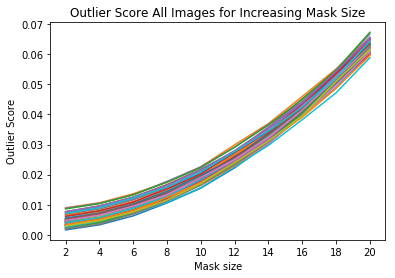

In [25]:
for ais in all_img_scores:
    plt.plot(x_plt, ais)
    plt.xticks(x_plt)
plt.title('Outlier Score All Images for Increasing Mask Size')
plt.xlabel('Mask size')
plt.ylabel('Outlier Score')
plt.show()

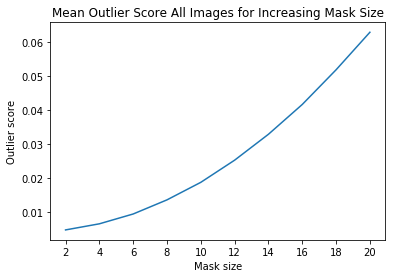

In [26]:
ais_np = np.zeros((len(all_img_scores), all_img_scores[0].shape[0]))
for i, ais in enumerate(all_img_scores):
    ais_np[i, :] = ais
ais_mean = np.mean(ais_np, axis=0)
plt.title('Mean Outlier Score All Images for Increasing Mask Size')
plt.xlabel('Mask size')
plt.ylabel('Outlier score')
plt.plot(x_plt, ais_mean)
plt.xticks(x_plt)
plt.show()

### Investigate instance level outlier

In [27]:
i = 8  # index of instance to look at

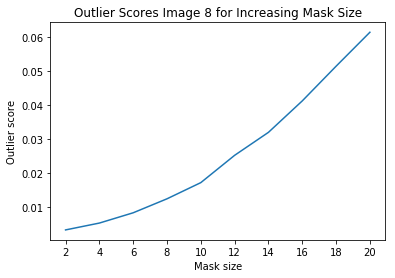

In [28]:
plt.plot(x_plt, all_img_scores[i])
plt.xticks(x_plt)
plt.title('Outlier Scores Image {} for Increasing Mask Size'.format(i))
plt.xlabel('Mask size')
plt.ylabel('Outlier score')
plt.show()

Reconstruction of masked images and outlier scores per channel:

In [29]:
all_X_mask = []
X_i = X_orig[i].reshape(1, 32, 32, 3)
all_X_mask.append(X_i)
# apply masks
for j, mask_size in enumerate(mask_sizes):
    # create masked instances
    X_mask, mask = apply_mask(X_i,
                              mask_size=mask_size,
                              n_masks=1,  # just 1 for visualization purposes
                              channels=[0,1,2],
                              mask_type='normal',
                              noise_distr=(0,1),
                              clip_rng=(0,1))
    all_X_mask.append(X_mask)
all_X_mask = np.concatenate(all_X_mask, axis=0)
all_X_recon = od.vae(all_X_mask).numpy()
od_preds = od.predict(all_X_mask)

Visualize:

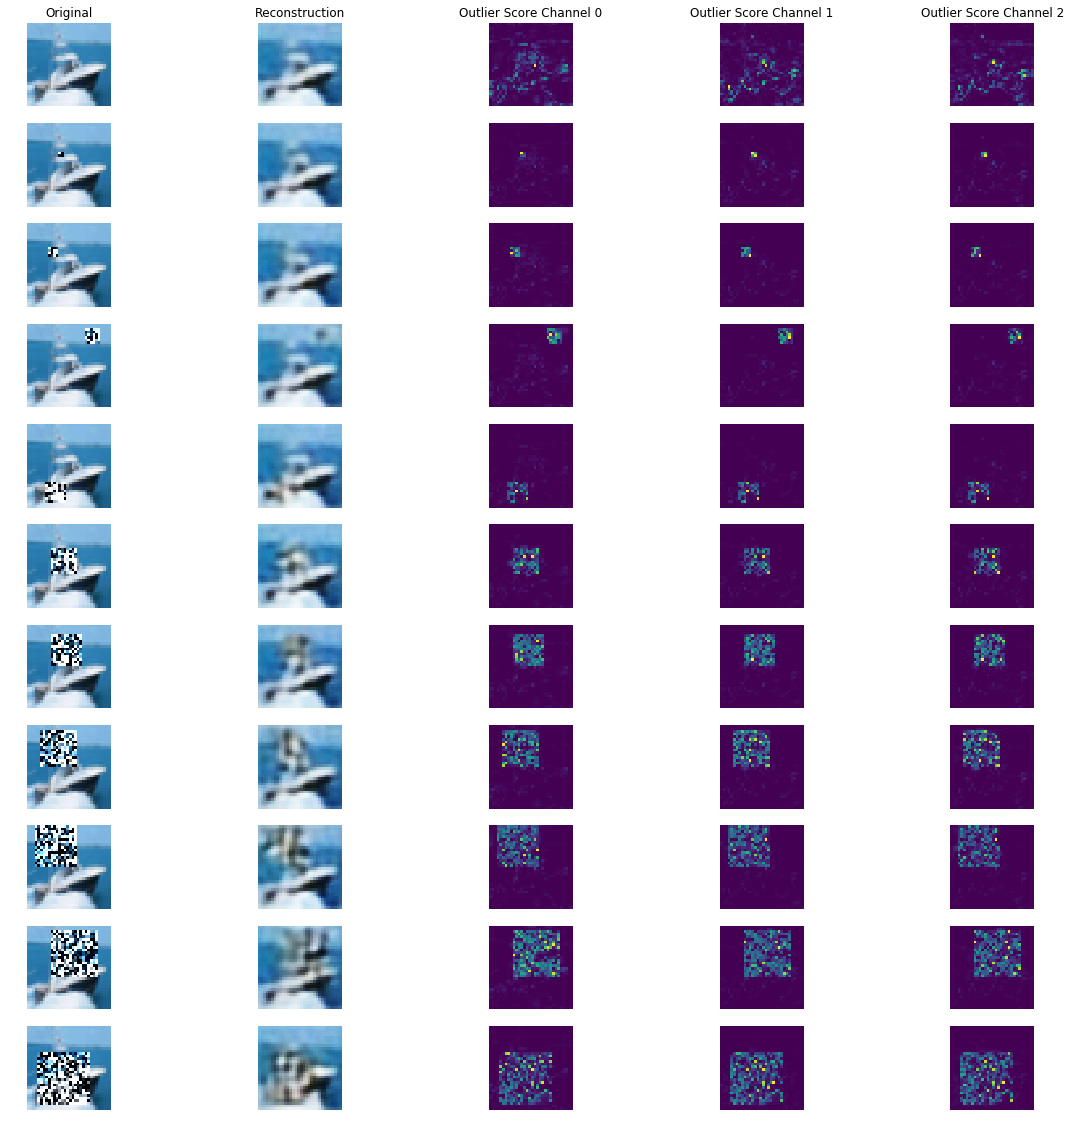

In [30]:
plot_feature_outlier_image(od_preds, 
                           all_X_mask, 
                           X_recon=all_X_recon, 
                           max_outliers=all_X_mask.shape[0], 
                           n_channels=3)

## Predict outliers on a subset of features

The sensitivity of the outlier detector can not only be controlled via the `threshold`, but also by selecting the percentage of the features used for the instance level outlier score computation. For instance, we might want to flag outliers if 40% of the features (pixels for images) have an average outlier score above the threshold. This is possible via the `outlier_perc` argument in the `predict` function. It specifies the percentage of the features that are used for outlier detection, sorted in descending outlier score order. 

In [31]:
perc_list = [20, 40, 60, 80, 100]

all_perc_scores = []
for perc in perc_list:
    od_preds_perc = od.predict(all_X_mask, outlier_perc=perc)
    iscore = od_preds_perc['data']['instance_score']
    all_perc_scores.append(iscore)

Visualize outlier scores vs. mask sizes and percentage of features used:

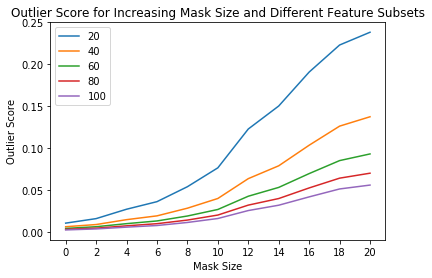

In [32]:
x_plt = [0] + x_plt
for aps in all_perc_scores:
    plt.plot(x_plt, aps)
    plt.xticks(x_plt)
plt.legend(perc_list)
plt.title('Outlier Score for Increasing Mask Size and Different Feature Subsets')
plt.xlabel('Mask Size')
plt.ylabel('Outlier Score')
plt.show()

## Infer outlier threshold value

Finding good threshold values can be tricky since they are typically not easy to interpret. The `infer_threshold` method helps finding a sensible value. We need to pass a batch of instances `X` and specify what percentage of those we consider to be normal via `threshold_perc`.

In [33]:
print('Current threshold: {}'.format(od.threshold))
od.infer_threshold(X, threshold_perc=99)  # assume 1% of the training data are outliers
print('New threshold: {}'.format(od.threshold))

Current threshold: 0.015
New threshold: 0.010572753958404063
